# Variational Monte Carlo simulation of Rydberg atoms

<br />

In this notebook, we show an application of recurrent neural networks (RNN) to discover the ground state of a many-body Hamiltonian. The RNN is used to parametrize the wavefunction of the Rydberg atoms, and its parameters are trained by minimizing the total energy using variational Monte Carlo. The RNN wavefunction and the training routines are implemented in the file `vmc.py`.

### Importing Tensorflow, Numpy, and Matplotlib 

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

### RNN wavefunction

In [20]:
class VariationalMonteCarlo(tf.keras.Model):

    # Constructor
    def __init__(self, Lx, Ly, 
                 V, Omega, delta,
                 num_hidden, learning_rate,
                 epochs, seed=1234):
        
        super(VariationalMonteCarlo, self).__init__()

        """ PARAMETERS """
        self.Lx       = Lx              # Size along x
        self.Ly       = Ly              # Size along y
        self.V        = V               # Van der Waals potential
        self.Omega    = Omega           # Rabi frequency
        self.delta    = delta           # Detuning

        self.N        = Lx * Ly         # Number of spins
        self.nh       = num_hidden      # Number of hidden units in the RNN
        self.seed     = seed            # Seed of random number generator
        self.epochs   = epochs          # Training epochs 
        self.K        = 2               # Dimension of the local Hilbert space

        # Set the seed of the rng
        tf.random.set_seed(self.seed)

        # Optimizer
        self.optimizer = tf.optimizers.Adam(learning_rate, epsilon=1e-8)

        # Build the model RNN
        # RNN layer: N -> nh
        self.rnn = tf.keras.layers.GRU(self.nh, kernel_initializer='glorot_uniform',
                                       kernel_regularizer = tf.keras.regularizers.l2(0.001),
                                       return_sequences = True,
                                       return_state = True,
                                       stateful = False)

        # Dense layer: nh - > K
        self.dense = tf.keras.layers.Dense(self.K, activation = tf.nn.softmax,
                                           kernel_regularizer = tf.keras.regularizers.l2(0.001))

        # Generate the list of bonds for NN,NNN,NNNN on a 
        # square lattice with open boundaries
        self.buildlattice()
    
    @tf.function
    def sample(self,nsamples):
        # Zero initialization for visible and hidden state 
        inputs = 0.0*tf.one_hot(tf.zeros(shape=[nsamples,1],dtype=tf.int32),depth=self.K)
        hidden_state = tf.zeros(shape=[nsamples,self.nh])

        logP = tf.zeros(shape=[nsamples,],dtype=tf.float32)

        for j in range(self.N):
            # Run a single RNN cell
            rnn_output,hidden_state = self.rnn(inputs,initial_state=hidden_state)
            # Compute log probabilities
            probs = self.dense(rnn_output)
            log_probs = tf.reshape(tf.math.log(1e-10+probs),[nsamples,self.K])
            # Sample
            sample = tf.random.categorical(log_probs,num_samples=1)
            if (j == 0):
                samples = tf.identity(sample)
            else:
                samples = tf.concat([samples,sample],axis=1)
            # Feed result to the next cell
            inputs = tf.one_hot(sample,depth=self.K)
            add = tf.reduce_sum(log_probs*tf.reshape(inputs,(nsamples,self.K)),axis=1)

            logP = logP+tf.reduce_sum(log_probs*tf.reshape(inputs,(nsamples,self.K)),axis=1)

        return samples,logP

    @tf.function
    def logpsi(self,samples):
        # Shift data
        num_samples = tf.shape(samples)[0]
        data   = tf.one_hot(samples[:,0:self.N-1],depth=self.K)

        x0 = 0.0*tf.one_hot(tf.zeros(shape=[num_samples,1],dtype=tf.int32),depth=self.K)
        inputs = tf.concat([x0,data],axis=1)

        hidden_state = tf.zeros(shape=[num_samples,self.nh])
        rnn_output,_ = self.rnn(inputs,initial_state = hidden_state)
        probs        = self.dense(rnn_output)

        log_probs   = tf.reduce_sum(tf.multiply(tf.math.log(1e-10+probs),tf.one_hot(samples,depth=self.K)),axis=2)

        return 0.5*tf.reduce_sum(log_probs,axis=1)

    #@tf.function
    def localenergy(self,samples,logpsi):
        eloc = tf.zeros(shape=[tf.shape(samples)[0]],dtype=tf.float32)

        # Chemical potential
        for j in range(self.N):
            eloc += - self.delta * tf.cast(samples[:,j],tf.float32)
        # NN
        for n in range(len(self.nn)):
            eloc += self.V * tf.cast(samples[:,self.nn[n][0]]*samples[:,self.nn[n][1]],tf.float32)
        for n in range(len(self.nnn)):
            eloc += (self.V/8.0) * tf.cast(samples[:,self.nnn[n][0]]*samples[:,self.nnn[n][1]],tf.float32)
        for n in range(len(self.nnnn)):
            eloc += (self.V/64.0) * tf.cast(samples[:,self.nnnn[n][0]]*samples[:,self.nnnn[n][1]],tf.float32)

        # Off-diagonal part
        for j in range(self.N):
            flip_samples = np.copy(samples)
            flip_samples[:,j] = 1 - flip_samples[:,j]
            flip_logpsi = self.logpsi(flip_samples)
            eloc += -0.5*self.Omega * tf.math.exp(flip_logpsi-logpsi)

        return eloc

    """ Generate the square lattice structures """
    def coord_to_site(self,x,y):
        return self.Ly*x+y
    
    def buildlattice(self):
        self.nn = []
        self.nnn = []
        self.nnnn = []
        for x in range(self.Lx):
            for y in range(self.Ly-1):
                self.nn.append([self.coord_to_site(x,y),self.coord_to_site(x,y+1)])
        for y in range(self.Ly):
            for x in range(self.Lx-1):
                self.nn.append([self.coord_to_site(x,y),self.coord_to_site(x+1,y)])

        for y in range(self.Ly-1):
            for x in range(self.Lx-1):
                self.nnn.append([self.coord_to_site(x,y),self.coord_to_site(x+1,y+1)])
                self.nnn.append([self.coord_to_site(x+1,y),self.coord_to_site(x,y+1)])

        for y in range(self.Ly):
            for x in range(self.Lx-2):
                self.nnnn.append([self.coord_to_site(x,y),self.coord_to_site(x+2,y)])
        for y in range(self.Ly-2):
            for x in range(self.Lx):
                self.nnnn.append([self.coord_to_site(x,y),self.coord_to_site(x,y+2)])


### Upload QMC Data Files

In [21]:
from google.colab import files
uploaded = files.upload()


Saving samples_9.txt to samples_9 (10).txt
Saving samples_8.txt to samples_8 (10).txt
Saving samples_7.txt to samples_7 (10).txt
Saving samples_6.txt to samples_6 (10).txt
Saving samples_5.txt to samples_5 (10).txt
Saving samples_4.txt to samples_4 (10).txt
Saving samples_3.txt to samples_3 (10).txt
Saving samples_2.txt to samples_2 (10).txt
Saving samples_10.txt to samples_10 (10).txt
Saving samples_1.txt to samples_1 (10).txt


In [10]:
# uploaded

In [22]:
def create_tf_dataset(uploaded_files, data_step_size=100):
  data = []
  for file in uploaded_files:
    new_data = uploaded_files[file].decode("utf-8").split("\n")[:-1] # last element is empty due to extra "\n"
    new_data = [list(map(int, entry.split())) for entry in new_data]
    new_data = new_data[::data_step_size]
    print("New data shape: ", np.array(new_data).shape)
    data.extend(new_data)

  #convert to tf.data.Dataset
  data = np.array(data)
  print("Overall dataset shape: ", data.shape) #shape = (Num_examples, N)
  dataset = tf.data.Dataset.from_tensor_slices(data)
  return dataset

In [23]:
qmc_dataset = create_tf_dataset(uploaded, data_step_size=1000)

New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
New data shape:  (100, 16)
Overall dataset shape:  (1000, 16)


### Define Parameters

In [33]:
# Hamiltonian parameters
Lx = 4     # Linear size in x direction
Ly = 4      # Linear size in y direction
N = Lx*Ly   # Total number of atoms
V = 7.0     # Strength of Van der Waals interaction
Omega = 1.0 # Rabi frequency
delta = 1.0 # Detuning 

# RNN-VMC parameters
lr = 0.001     # learning rate of Adam optimizer
nh = 32        # Number of hidden units in the GRU cell
ns = 1000     # Number of samples used to approximate the energy at each step
vmc_epochs = 500  # Training iterations for vmc
qmc_epochs = 500    # Training iterations for qmc
seed = 1234    # Seed of RNG

# Exact energy from exact diagonalization for L=4, and DMRG for higher L
exact_energy = {4:-0.45776822, 8: -0.41079068589921375
, 12: -0.3952409191423294, 16:-0.38780030058038656}

### Run VMC using QMC data or sampling

In [34]:
def run_VMC(vmc, epochs, delta, qmc_data, energy, variance, batch_size=100):
    if qmc_data != None:
      print("Running VMC using QMC data for delta = ", delta)
    else:
      print("Running VMC for delta =",delta)

    for n in tqdm(range(1,epochs+1)):
      samples, _ = vmc.sample(ns)
      
      # Evaluate the loss function in AD mode
      with tf.GradientTape() as tape:
          sample_logpsi = vmc.logpsi(samples)
          sample_eloc = vmc.localenergy(samples, sample_logpsi)
          sample_Eo = tf.stop_gradient(tf.reduce_mean(sample_eloc))

          sample_loss = tf.reduce_mean(2.0*tf.multiply(sample_logpsi, tf.stop_gradient(sample_eloc)) - 2.0*sample_Eo*sample_logpsi)


      #use qmc_data to update RNN weights
      if qmc_data != None:
          dset = qmc_data.shuffle(len(qmc_data))
          dset = dset.batch(batch_size, num_parallel_calls=5, deterministic=False)
        
          for i, batch in enumerate(dset):
              # Evaluate the loss function in AD mode
              with tf.GradientTape() as tape:
                  logpsi = vmc.logpsi(batch)
                  eloc = vmc.localenergy(batch, logpsi)
                  Eo = tf.stop_gradient(tf.reduce_mean(eloc))

                  loss = tf.reduce_mean(2.0*tf.multiply(logpsi, tf.stop_gradient(eloc)) - 2.0*Eo*logpsi)

              # Compute the gradients either with qmc_loss
              gradients = tape.gradient(loss, vmc.trainable_variables)
              
              # Update the parameters
              vmc.optimizer.apply_gradients(zip(gradients, vmc.trainable_variables))
      else:
        # Compute the gradients either with sample_loss
        gradients = tape.gradient(sample_loss, vmc.trainable_variables)
        
        # Update the parameters
        vmc.optimizer.apply_gradients(zip(gradients, vmc.trainable_variables))
           
      #append the energy to see convergence
      energies = sample_eloc.numpy()
      avg_E = np.mean(energies)/float(N)
      var_E = np.var(energies)/float(N)
      energy.append(avg_E) #average over samples

    return vmc, energy, variance

In [35]:
def plot_E(energy, exact_energy, N, vmc_epochs, qmc_epochs):
  fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')

  plt.plot(energy,marker='o',markersize=2,linewidth=0.0,markevery=1,label="RNN")
  plt.hlines(exact_energy,0,vmc_epochs+qmc_epochs,linestyle="--",label="Exact")
  if qmc_epochs != 0:
    plt.vlines(qmc_epochs, energy[0], exact_energy, linestyle="--", label="QMC train cutoff")

  plt.xlabel("Step",fontsize=15)
  plt.ylabel("$\\langle H \\rangle$",fontsize=20)
  plt.title("{} sites".format(N))
  plt.legend(loc="best")

  plt.show()

  final_energy = energy[-1]
  final_error = np.abs(final_energy-exact_energy)
  print("Final Error after {} epochs is {}".format(vmc_epochs+qmc_epochs, final_error))
  print("Final Energy {}".format(final_energy))
  return final_energy

### Run VMC with sampling

In [36]:
vmc = VariationalMonteCarlo(Lx,Ly,V,Omega,delta,nh,lr,vmc_epochs,seed)
energy = []
variance = []
vmc, energy, variance = run_VMC(vmc, vmc_epochs+qmc_epochs, delta, None, energy, variance)

Running VMC for delta = 1.0


100%|██████████| 1000/1000 [08:48<00:00,  1.89it/s]


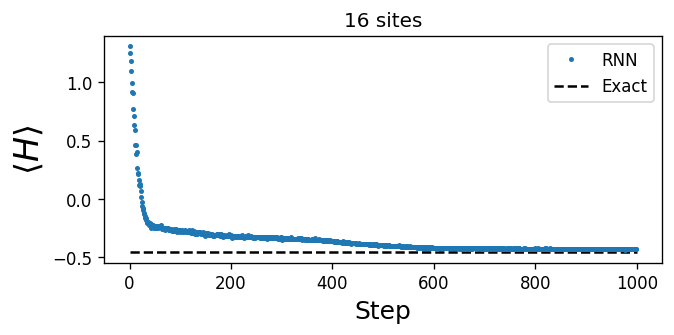

Final Error after 1000 epochs is 0.029518652252883915
Final Energy -0.4282495677471161


In [37]:
vmc_final_energy = plot_E(energy, exact_energy[Lx], N, vmc_epochs+qmc_epochs, qmc_epochs=0)

### Run VMC using QMC data

In [38]:
vmc_qmc = VariationalMonteCarlo(Lx,Ly,V,Omega,delta,nh,lr,vmc_epochs,seed)
energy = []
variance = []
vmc_qmc, energy, variance = run_VMC(vmc_qmc, qmc_epochs, delta, qmc_dataset, energy, variance)

Running VMC using QMC data for delta =  1.0


100%|██████████| 500/500 [22:19<00:00,  2.68s/it]


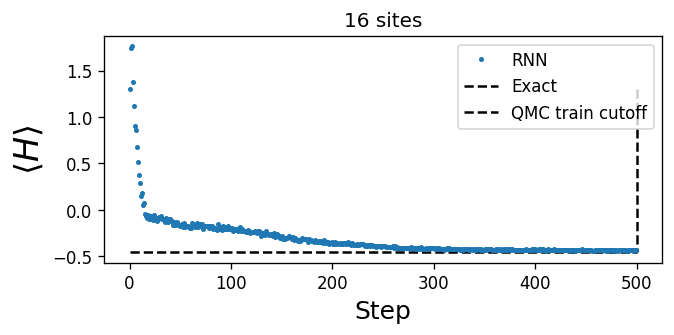

Final Error after 500 epochs is 0.02669893532249451
Final Energy -0.4310692846775055


In [39]:
qmc_final_energy = plot_E(energy, exact_energy[Lx], N, 0, qmc_epochs)

### Continue training from QMC data training

In [40]:
vmc_qmc, energy, variance = run_VMC(vmc_qmc, vmc_epochs, delta, None, energy, variance)

Running VMC for delta = 1.0


100%|██████████| 500/500 [04:18<00:00,  1.93it/s]


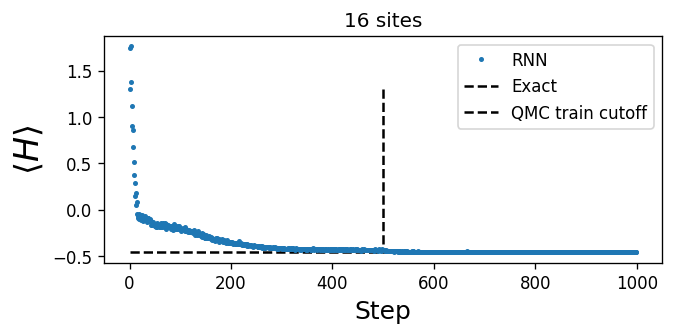

Final Error after 1000 epochs is 0.0020479443595123326
Final Energy -0.45572027564048767


In [41]:
qmc_vmc_final_energy = plot_E(energy, exact_energy[Lx], N, vmc_epochs, qmc_epochs)

In [42]:
print(len(energy))

1000


# Experiments summary


## Fixed parameters
batch_size = 100



**4 x 4**
- Exact Energy: -0.45776822
- Hidden units = 32

**VMC:** 
- samples = 1000, epochs = 1000
- Final Energy = -0.428250
- Final Error = 0.029519
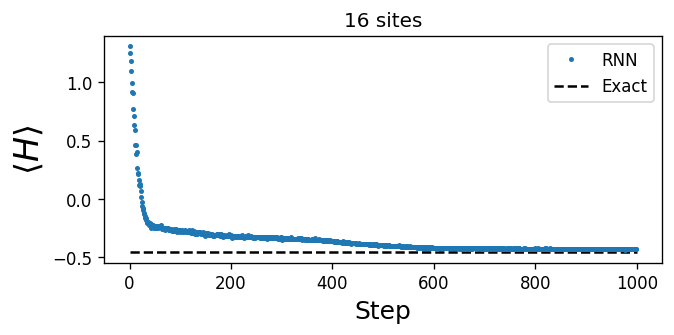


**QMC:**
- data = 1000, epochs = 500
- Final Energy = -0.43107
- Final Error = 0.026699

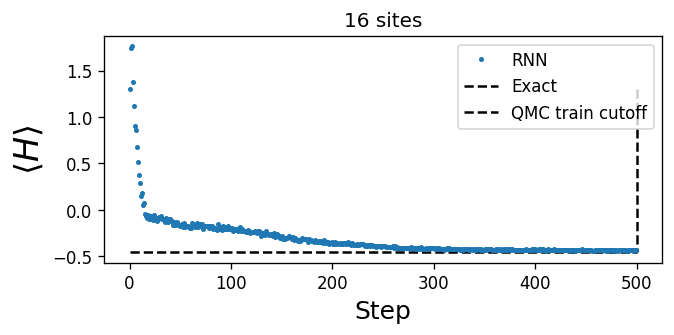

**QMC & VMC:**
- *Continuing using VMC from QMC*
  - samples = 1000, epochs = 500
  - Final Energy = -0.45572
  - Final Error = 0.002048


  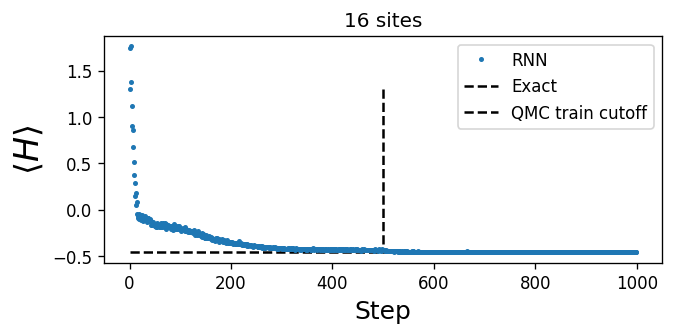

  

**8 x 8**
- DMRG Energy = -0.4870843
- QMC Energy =  -0.41079068589921375 +/- 0.00015929597162506545
- Hidden units = 50

**VMC:** 
- samples = 500, epochs = 500
- Final Energy = -0.3373688
- Final Error = 0.073421
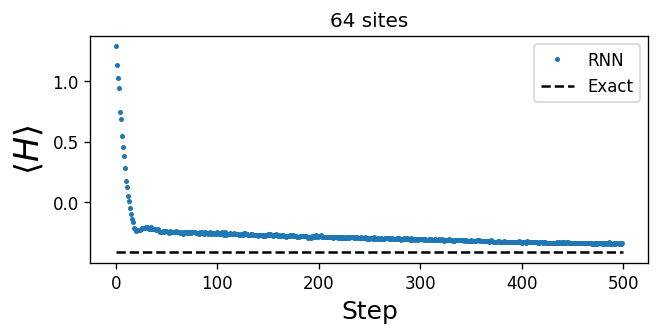

**QMC:**
- data = 1000, epochs = 100
- Final Energy = -0.21488
- Final Error = 0.1959

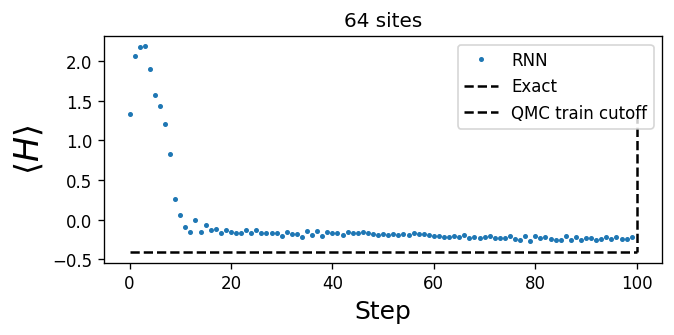

**QMC & VMC:** 
- *Continuing VMC from QMC*
  - samples = 500, epochs = 400
  - Final Energy = -0.38104
  - Final Error = 0.02975

  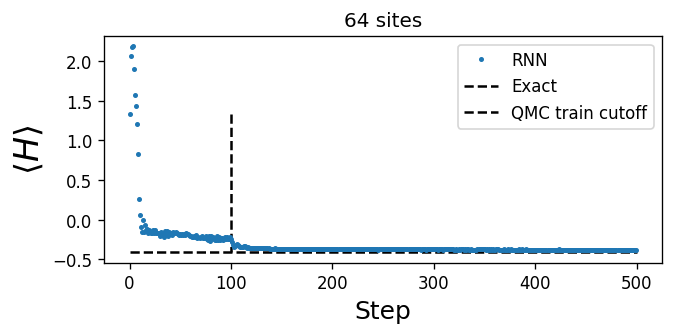

**12 x 12**
- QMC Energy =  -0.3952409191423294 +/- 0.00017185961929073537
- Hidden units = 16

**VMC:** 
- samples = 500, epochs = 250
- Final Energy = -0.271778
- Final Error = 0.123463

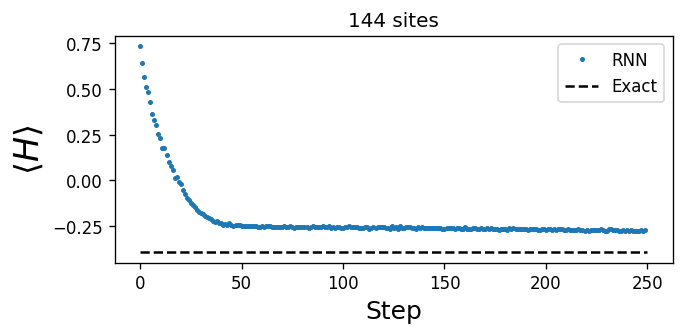

**QMC:**
- data = 1000, epochs = 50
- Final Energy = -0.15205
- Final Error = 0.243189

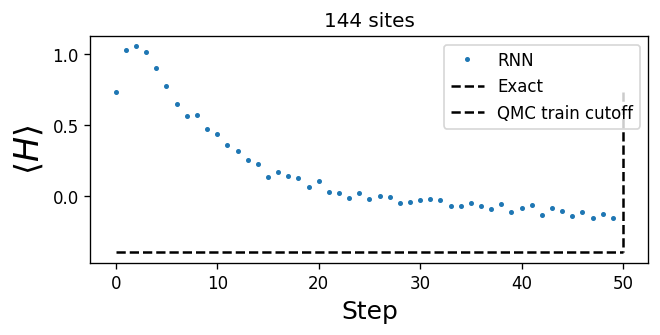

**QMC & VMC:**
- *Continuing VMC from QMC*
  - samples = 500, epochs = 200
  - Final Energy = -0.3228 
  - Final Error = 0.07244

  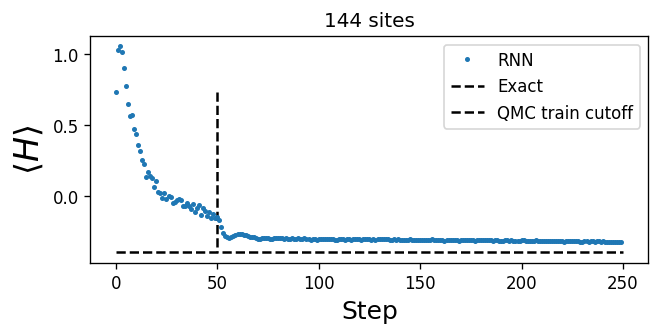

**16 x 16**
- QMC Energy =  -0.38780030058038656 +/- 0.0001786777979472486
- Hidden units = 4

**VMC:** 
- samples = 300, epochs = 100
- Final Energy = -0.04187
- Final Error = 0.34593
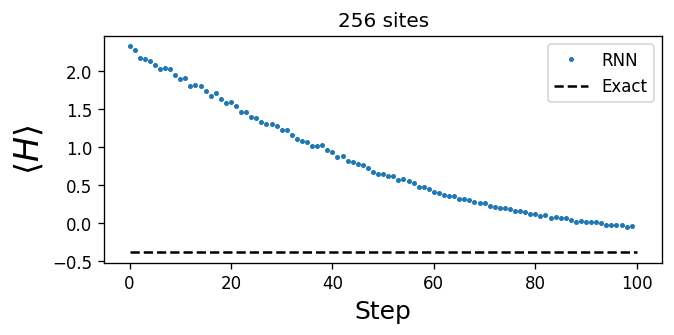

**QMC:**
- data = 1000, epochs = 25
- Final Energy = 2.2677
- Final Error = 1.8799
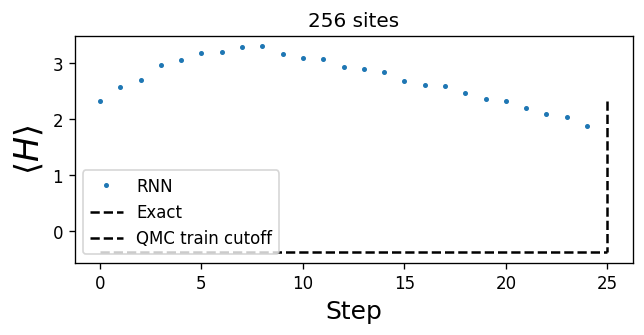
**QMC & VMC:**
- *Continuing VMC from QMC*
  - samples = 300, epochs = 75
  - Final Energy = -0.25963
  - Final Error = 0.12816


  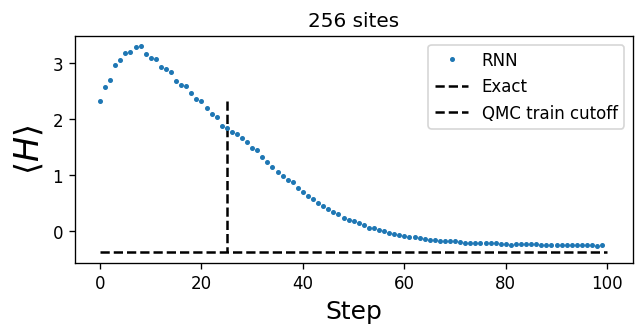